## Import Libraries

In [1]:
from scipy.io import wavfile as wav
import librosa
import sounddevice as sd
import IPython.display as ipd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
import keras
from keras.utils import np_utils
import matplotlib as mpl

Using TensorFlow backend.


In [2]:
duration = 2 # (secondi)
rec_rate = 44100

## data load

In [710]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

        
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)           

    return X_train, X_test, y_train, y_test

In [711]:
def mfcc(input, rate=rec_rate):
    # Calcola coefficienti MFCC
    mfcc = np.mean(librosa.feature.mfcc(input*1.0, sr=int(rate), n_mfcc=20).T, axis=0)
    return mfcc

In [712]:
# Caricamento dati
X_train, X_test, y_train, y_test = load_data(feature_extractor=mfcc)

In [713]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [714]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [715]:
Y_train = np_utils.to_categorical(y_train,4)
Y_test = np_utils.to_categorical(y_test,4)

In [716]:
X_train.shape

(192, 20)

## Model

In [717]:
 def make_model():
  model = keras.Sequential([
      keras.layers.Dense(32, 
                        activation='relu',
                        #dropout = 0.3, 
                        #recurrent_dropout = 0.3, 
                        #return_sequences= True, 
                        input_shape=(20,)),
      keras.layers.Dense(64, 
                        activation='relu',
                        #dropout = 0.3, 
                        #recurrent_dropout = 0.3, 
                        #return_sequences= False
                        ),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(4, activation='softmax'),
  ])
  model.compile(
      optimizer=keras.optimizers.RMSprop(),
      loss=keras.losses.categorical_crossentropy,
  metrics=['accuracy'])

  return model

In [718]:
model = make_model()
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                672       
_________________________________________________________________
dense_61 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 260       
Total params: 3,044
Trainable params: 3,044
Non-trainable params: 0
_________________________________________________________________


In [723]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [724]:
baseline_history = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    validation_data = (X_test, Y_test),
    callbacks = [early_stopping],
    epochs=300)

Train on 192 samples, validate on 48 samples
Epoch 1/300
192/192 [==============================] - 0s 95us/step - loss: 0.2168 - accuracy: 0.9167 - val_loss: 0.0660 - val_accuracy: 1.0000
Epoch 2/300
192/192 [==============================] - 0s 89us/step - loss: 0.2103 - accuracy: 0.9062 - val_loss: 0.0972 - val_accuracy: 0.9583
Epoch 3/300
192/192 [==============================] - 0s 101us/step - loss: 0.2350 - accuracy: 0.9010 - val_loss: 0.0886 - val_accuracy: 0.9583
Epoch 4/300
192/192 [==============================] - 0s 102us/step - loss: 0.2015 - accuracy: 0.9375 - val_loss: 0.0764 - val_accuracy: 0.9583
Epoch 5/300
192/192 [==============================] - 0s 110us/step - loss: 0.1969 - accuracy: 0.9167 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 6/300
192/192 [==============================] - 0s 104us/step - loss: 0.1620 - accuracy: 0.9583 - val_loss: 0.0625 - val_accuracy: 0.9792
Epoch 7/300
192/192 [==============================] - 0s 118us/step - loss: 0.1614 - a

In [725]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 
             color=colors[0],
             label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0.2,1])
    else:
      plt.ylim([0,1])

    plt.legend()

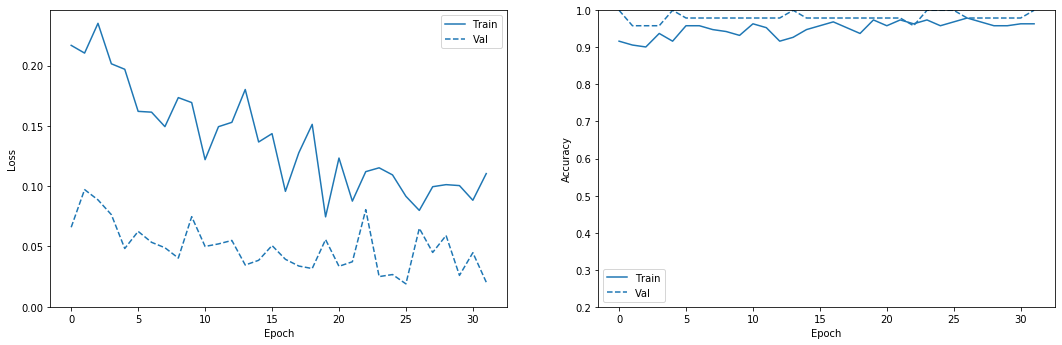

In [726]:
plot_metrics(baseline_history)

Report di classificazione modello:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.80      0.89         5
           2       1.00      0.93      0.96        14
           3       0.94      1.00      0.97        17

    accuracy                           0.96        48
   macro avg       0.97      0.93      0.95        48
weighted avg       0.96      0.96      0.96        48

Matrice di confusione modello:
[[12  0  0  0]
 [ 1  4  0  0]
 [ 0  0 13  1]
 [ 0  0  0 17]]


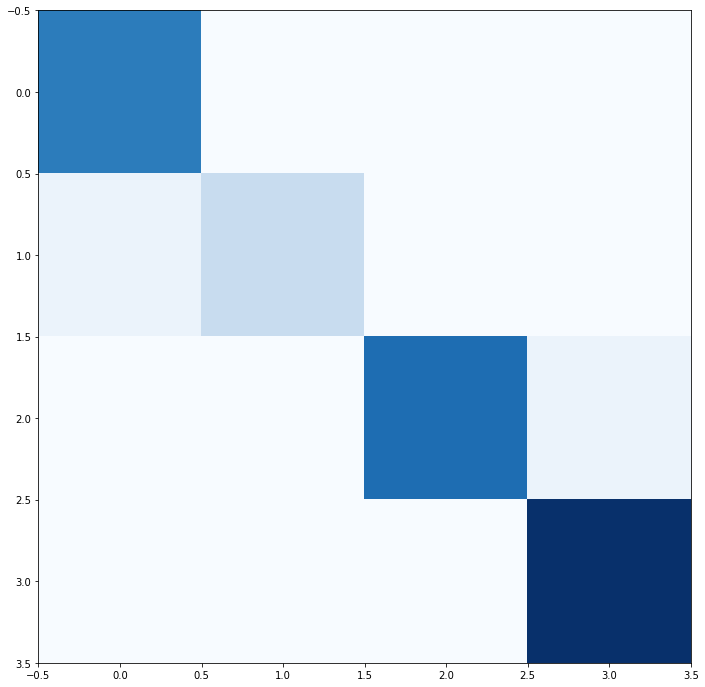

In [727]:
y_pred = model.predict_classes(X_test) 
y_test = y_test.astype("int")
# Report di classificazione
print("Report di classificazione modello:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione modello:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In [813]:
model.save("RNN.h5")

## Demo

In [806]:
prova = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)

In [807]:
librosa.output.write_wav('test.wav', prova, rec_rate)

In [808]:
rec_rate, rec = wav.read('test.wav')

In [809]:
mfcc = np.mean(librosa.feature.mfcc(rec*1.0, sr=int(rec_rate), n_mfcc=20).T, axis=0)

mfcc = np.array(mfcc)
mfcc = mfcc.reshape(1,mfcc.shape[0])

In [810]:
mfcc.shape

(1, 20)

In [811]:
preds_audio = model.predict(mfcc)
if max(preds_audio[0]) < 0.7:   
    preds_audio = 4  
else:   
    preds_audio = np.argmax(preds_audio)

In [812]:
if preds_audio==0:
    print("Raffaele ha detto acconsento")
    
elif preds_audio == 1:
    print("Raffaele ha detto rifiuto")

elif preds_audio == 2:
    print("Lorenzo ha detto acconsento")
    
elif preds_audio == 3:
    print("Lorenzo ha detto rifiuto")
    
else:
    print("Riprova")

Lorenzo ha detto rifiuto


In [805]:
ipd.Audio(rec, rate=44100)